<a href="https://colab.research.google.com/github/Niharika-Saha/Adaptive-Bacterial-Antibiotic-Resistance-Prediction-using-Meta-Learning/blob/protoMAML/ProtoMAML_Deeper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================
# Advanced Encoder Architectures with Meta-Baseline Training
# Person 1: Representation & Encoders
# ============================================================

# Cell 1: Imports and Setup (reuse from original)
import os, random, numpy as np, pandas as pd, torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
CSV_PATH = "/content/dataset.csv"
df = pd.read_csv(CSV_PATH)
df = df.dropna(subset=["sequence","mechanism"]).reset_index(drop=True)
df["sequence"] = df["sequence"].str.upper().str.replace(r"[^ACGT]", "", regex=True)
print("Dataset:", df.shape, " | unique mechanisms:", df["mechanism"].nunique())

Dataset: (8733, 9)  | unique mechanisms: 233


In [ ]:
# Cell 3: Mechanism split
mechs = np.array(sorted(df["mechanism"].unique()))
train_mechs, temp_mechs = train_test_split(mechs, test_size=0.30, random_state=RANDOM_SEED, shuffle=True)
val_mechs, test_mechs = train_test_split(temp_mechs, test_size=0.50, random_state=RANDOM_SEED, shuffle=True)

train_df = df[df.mechanism.isin(train_mechs)].reset_index(drop=True)
val_df = df[df.mechanism.isin(val_mechs)].reset_index(drop=True)
test_df = df[df.mechanism.isin(test_mechs)].reset_index(drop=True)

print(f"Train/Val/Test mechanisms: {len(train_mechs)}/{len(val_mechs)}/{len(test_mechs)}")
print(f"Train/Val/Test samples: {len(train_df)}/{len(val_df)}/{len(test_df)}")

Train/Val/Test mechanisms: 163/35/35
Train/Val/Test samples: 7557/774/402


In [ ]:
# Cell 4: Tokenization (same as original)
KMER_K = 5
PAD, UNK = "<PAD>", "<UNK>"

def kmers_from_seq(seq, k=KMER_K):
    L = len(seq)
    if L < k:
        return []
    return [seq[i:i+k] for i in range(L-k+1)]

from collections import Counter
counter = Counter()
for s in train_df["sequence"]:
    counter.update(kmers_from_seq(s, KMER_K))

tokens = [PAD, UNK] + sorted(counter.keys())
stoi = {t:i for i,t in enumerate(tokens)}
itos = {i:t for t,i in stoi.items()}
VOCAB_SIZE = len(stoi)
print("Vocab size:", VOCAB_SIZE)

def encode_ids(seq, k=KMER_K):
    arr = kmers_from_seq(seq, k)
    if not arr:
        return [stoi[UNK]]
    return [stoi.get(tok, stoi[UNK]) for tok in arr]

def encode_df_to_ids(dfp):
    ids = [encode_ids(s, KMER_K) for s in dfp["sequence"].tolist()]
    nums = dfp[["gc_content","seq_len"]].to_numpy(np.float32)
    y = dfp["mechanism"].to_numpy()
    return ids, nums, y

train_ids, train_num, ytr = encode_df_to_ids(train_df)
val_ids, val_num, yva = encode_df_to_ids(val_df)
test_ids, test_num, yte = encode_df_to_ids(test_df)

Vocab size: 1026


In [ ]:
# Cell 5: Padding and standardization
MAX_LEN = 512
print("MAX_LEN:", MAX_LEN)

def pad_sequences(list_of_ids, max_len=MAX_LEN, pad_id=None):
    if pad_id is None:
        pad_id = stoi[PAD]
    out = np.full((len(list_of_ids), max_len), pad_id, dtype=np.int64)
    for i, seq in enumerate(list_of_ids):
        s = seq[:max_len]
        out[i, :len(s)] = s
    return out

Xtr_tok = pad_sequences(train_ids, MAX_LEN)
Xva_tok = pad_sequences(val_ids, MAX_LEN)
Xte_tok = pad_sequences(test_ids, MAX_LEN)

# Standardize numeric features
num_mean = train_num.mean(axis=0, keepdims=True)
num_std = train_num.std(axis=0, keepdims=True) + 1e-6
train_num = (train_num - num_mean)/num_std
val_num = (val_num - num_mean)/num_std
test_num = (test_num - num_mean)/num_std

# Label encoding for supervised training
from sklearn.preprocessing import LabelEncoder
le_train = LabelEncoder()
ytr_int = le_train.fit_transform(ytr)
num_train_classes = len(le_train.classes_)
print(f"Number of training classes: {num_train_classes}")

MAX_LEN: 512
Number of training classes: 163


In [ ]:
# Cell 6: Episodic sampling utilities (same as original)
from collections import defaultdict

def mech_index(y):
    d = defaultdict(list)
    for i, lab in enumerate(y):
        d[lab].append(i)
    return {k: np.asarray(v, dtype=int) for k,v in d.items()}

def create_tasks(X_tok, X_num, y, idx_map, num_tasks=1000, N=3, K=3, Q=5, seed=42):
    rng = np.random.default_rng(seed)
    tasks = []
    valid = [m for m, ids in idx_map.items() if len(ids) >= K + Q]
    if len(valid) < N:
        return tasks

    for _ in range(num_tasks):
        me_sel = rng.choice(valid, size=N, replace=False)
        s_tok, s_num, s_y = [], [], []
        q_tok, q_num, q_y = [], [], []
        for j, m in enumerate(me_sel):
            ids = rng.choice(idx_map[m], size=K + Q, replace=False)
            s, q = ids[:K], ids[K:K+Q]
            s_tok.append(X_tok[s])
            q_tok.append(X_tok[q])
            s_num.append(X_num[s])
            q_num.append(X_num[q])
            s_y.append(np.full(K, j, np.int64))
            q_y.append(np.full(Q, j, np.int64))

        tasks.append({
            "s_tok": np.vstack(s_tok),
            "s_num": np.vstack(s_num),
            "s_y": np.concatenate(s_y),
            "q_tok": np.vstack(q_tok),
            "q_num": np.vstack(q_num),
            "q_y": np.concatenate(q_y),
            "mechs": list(me_sel)
        })
    return tasks

idx_tr, idx_va, idx_te = mech_index(ytr), mech_index(yva), mech_index(yte)
N, K, Q = 3, 3, 5

val_tasks = create_tasks(Xva_tok, val_num, yva, idx_va, num_tasks=300, N=N, K=K, Q=Q, seed=RANDOM_SEED)
test_tasks = create_tasks(Xte_tok, test_num, yte, idx_te, num_tasks=500, N=N, K=K, Q=Q, seed=RANDOM_SEED)

print(f"Tasks | val:{len(val_tasks)} test:{len(test_tasks)} (N={N},K={K},Q={Q})")

Tasks | val:300 test:500 (N=3,K=3,Q=5)


In [ ]:
# ============================================================
# ENCODER ARCHITECTURES
# ============================================================

# Cell 7: Architecture 1 - CNN + BiLSTM Encoder
class CNNBiLSTMEncoder(nn.Module):
    """CNN for local patterns + BiLSTM for sequential dependencies"""
    def __init__(self, vocab_size, pad_idx, max_len, embed_dim=256, token_dim=128,
                 conv_channels=96, kernel_sizes=(3,5,7), lstm_hidden=128,
                 lstm_layers=2, num_features=2):
        super().__init__()
        self.pad_idx = pad_idx

        # Token embedding
        self.emb = nn.Embedding(vocab_size, token_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(0.20)

        # Multi-scale CNN
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(token_dim, conv_channels, kernel_size=k, padding=k//2),
                nn.ReLU(),
                nn.BatchNorm1d(conv_channels),
                nn.Dropout1d(0.10)
            ) for k in kernel_sizes
        ])

        # BiLSTM over concatenated CNN features
        cnn_out_dim = conv_channels * len(kernel_sizes)
        self.lstm = nn.LSTM(
            cnn_out_dim,
            lstm_hidden,
            num_layers=lstm_layers,
            bidirectional=True,
            batch_first=True,
            dropout=0.20 if lstm_layers > 1 else 0
        )

        # Numeric feature projection
        self.num_proj = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
        )

        # Final projection
        lstm_out_dim = lstm_hidden * 2  # bidirectional
        fused_in = lstm_out_dim + 32
        self.proj = nn.Sequential(
            nn.Linear(fused_in, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.50),
            nn.Linear(512, embed_dim)
        )

    def forward(self, tokens, nums):
        # Embedding
        x = self.emb(tokens)  # [B, L, token_dim]
        x = self.emb_dropout(x)
        x = x.transpose(1, 2)  # [B, token_dim, L]

        # Multi-scale CNN
        conv_outs = []
        for conv in self.convs:
            conv_outs.append(conv(x))
        x = torch.cat(conv_outs, dim=1)  # [B, cnn_out_dim, L]
        x = x.transpose(1, 2)  # [B, L, cnn_out_dim]

        # BiLSTM
        lstm_out, (h_n, c_n) = self.lstm(x)  # lstm_out: [B, L, lstm_out_dim]

        # Use final hidden states from both directions
        h_forward = h_n[-2, :, :]  # Last layer, forward
        h_backward = h_n[-1, :, :]  # Last layer, backward
        h_lstm = torch.cat([h_forward, h_backward], dim=1)

        # Numeric features
        h_num = self.num_proj(nums)

        # Fuse and project
        h = torch.cat([h_lstm, h_num], dim=1)
        z = self.proj(h)
        z = F.normalize(z, p=2, dim=1)

        return z


In [ ]:
# Cell 8: Architecture 2 - 1D Transformer Encoder
class TransformerEncoder(nn.Module):
    """Transformer encoder over token sequence"""
    def __init__(self, vocab_size, pad_idx, max_len, embed_dim=256, token_dim=128,
                 n_heads=8, n_layers=4, ff_dim=512, num_features=2):
        super().__init__()
        self.pad_idx = pad_idx
        self.token_dim = token_dim

        # Token embedding
        self.emb = nn.Embedding(vocab_size, token_dim, padding_idx=pad_idx)
        self.pos_encoding = nn.Parameter(torch.randn(1, max_len, token_dim))
        self.emb_dropout = nn.Dropout(0.20)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=token_dim,
            nhead=n_heads,
            dim_feedforward=ff_dim,
            dropout=0.20,
            batch_first=True,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Numeric feature projection
        self.num_proj = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
        )

        # Final projection
        fused_in = token_dim + 32
        self.proj = nn.Sequential(
            nn.Linear(fused_in, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.50),
            nn.Linear(512, embed_dim)
        )

    def forward(self, tokens, nums):
        B, L = tokens.shape

        # Create padding mask
        pad_mask = (tokens == self.pad_idx)

        # Embedding + positional encoding
        x = self.emb(tokens)  # [B, L, token_dim]
        x = x + self.pos_encoding[:, :L, :]
        x = self.emb_dropout(x)

        # Transformer encoding
        x = self.transformer(x, src_key_padding_mask=pad_mask)  # [B, L, token_dim]

        # Pool: mean over non-padded tokens
        mask_expanded = (~pad_mask).unsqueeze(-1).float()
        x_sum = (x * mask_expanded).sum(dim=1)
        x_count = mask_expanded.sum(dim=1).clamp(min=1)
        h_text = x_sum / x_count

        # Numeric features
        h_num = self.num_proj(nums)

        # Fuse and project
        h = torch.cat([h_text, h_num], dim=1)
        z = self.proj(h)
        z = F.normalize(z, p=2, dim=1)

        return z



In [ ]:
# ============================================================
# META-BASELINE TRAINING
# ============================================================

# Cell 9: Stage 1 - Supervised Pre-training
def train_supervised(model, X_tok, X_num, y_int, num_classes,
                     batch_size=128, epochs=50, lr=1e-3, device='cuda'):
    """Stage 1: Standard supervised training on train mechanisms"""

    # Create classifier head
    classifier = nn.Linear(256, num_classes).to(device)

    # Combine into single model for training
    params = list(model.parameters()) + list(classifier.parameters())
    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # Prepare data
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_tok).long(),
        torch.from_numpy(X_num).float(),
        torch.from_numpy(y_int).long()
    )
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    best_loss = float('inf')
    train_losses = []
    train_accs = []

    print("\n=== Stage 1: Supervised Pre-training ===")
    for epoch in range(1, epochs + 1):
        model.train()
        classifier.train()

        epoch_loss = 0
        epoch_correct = 0
        epoch_total = 0

        for tok, num, labels in loader:
            tok, num, labels = tok.to(device), num.to(device), labels.to(device)

            optimizer.zero_grad()
            z = model(tok, num)
            logits = classifier(z)
            loss = F.cross_entropy(logits, labels)

            loss.backward()
            nn.utils.clip_grad_norm_(params, 5.0)
            optimizer.step()

            epoch_loss += loss.item() * len(labels)
            epoch_correct += (logits.argmax(1) == labels).sum().item()
            epoch_total += len(labels)

        scheduler.step()

        avg_loss = epoch_loss / epoch_total
        avg_acc = epoch_correct / epoch_total
        train_losses.append(avg_loss)
        train_accs.append(avg_acc)

        if epoch % 5 == 0 or epoch == epochs:
            print(f"Epoch {epoch}/{epochs} | Loss: {avg_loss:.4f} | Acc: {avg_acc:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss

    print(f"Stage 1 complete. Final accuracy: {train_accs[-1]:.4f}")
    return train_losses, train_accs

In [ ]:
# Cell 10: Stage 2 - Few-shot Evaluation with Frozen Encoder
def compute_prototypes(z, y_idx):
    classes = torch.unique(y_idx)
    protos = torch.stack([z[y_idx==c].mean(0) for c in classes], dim=0)
    return protos, classes

@torch.no_grad()
def evaluate_fewshot(model, tasks, device):
    """Stage 2: Evaluate frozen encoder on few-shot tasks"""
    model.eval()
    accs = []

    for t in tasks:
        s_tok = torch.from_numpy(t["s_tok"]).long().to(device)
        s_num = torch.from_numpy(t["s_num"]).float().to(device)
        q_tok = torch.from_numpy(t["q_tok"]).long().to(device)
        q_num = torch.from_numpy(t["q_num"]).float().to(device)
        s_y = torch.from_numpy(t["s_y"]).long().to(device)
        q_y = torch.from_numpy(t["q_y"]).long().to(device)

        # Get embeddings
        s_z = model(s_tok, s_num)
        q_z = model(q_tok, q_num)

        # Compute prototypes from support
        protos, _ = compute_prototypes(s_z, s_y)

        # Classify queries using cosine similarity
        logits = q_z @ protos.T
        preds = logits.argmax(1)

        acc = (preds == q_y).float().mean().item()
        accs.append(acc)

    return float(np.mean(accs)), float(np.std(accs))



In [ ]:
# Cell 11: t-SNE Analysis Function
@torch.no_grad()
def tsne_analysis(model, X_tok, X_num, y_labels, top_m=10, n_per_class=50,
                  device='cuda', subset_name='test'):
    """Generate t-SNE visualization and compute metrics"""
    model.eval()

    # Select top M classes
    unique, counts = np.unique(y_labels, return_counts=True)
    top_classes = unique[np.argsort(-counts)[:top_m]]

    # Sample from each class
    subset_indices = []
    subset_labels = []
    for cls in top_classes:
        cls_indices = np.where(y_labels == cls)[0]
        if len(cls_indices) > n_per_class:
            cls_indices = np.random.choice(cls_indices, n_per_class, replace=False)
        subset_indices.extend(cls_indices)
        subset_labels.extend([cls] * len(cls_indices))

    subset_indices = np.array(subset_indices)
    subset_labels = np.array(subset_labels)

    # Get embeddings
    X_tok_sub = X_tok[subset_indices]
    X_num_sub = X_num[subset_indices]

    tok_tensor = torch.from_numpy(X_tok_sub).long().to(device)
    num_tensor = torch.from_numpy(X_num_sub).float().to(device)

    Z = model(tok_tensor, num_tensor).cpu().numpy()

    # Compute t-SNE
    print(f"\nRunning t-SNE on {len(Z)} samples from {len(top_classes)} classes...")
    perplexity = min(30, max(5, len(Z) // 4 - 1))
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=RANDOM_SEED, verbose=0)
    Z2 = tsne.fit_transform(Z)

    # Compute metrics
    label_to_int = {lab: i for i, lab in enumerate(top_classes)}
    y_int = np.array([label_to_int[v] for v in subset_labels])

    sil = silhouette_score(Z2, y_int, metric="euclidean")

    kmeans = KMeans(n_clusters=len(top_classes), n_init="auto", random_state=RANDOM_SEED)
    pred = kmeans.fit_predict(Z2)
    ari = adjusted_rand_score(y_int, pred)
    nmi = normalized_mutual_info_score(y_int, pred)

    D = pairwise_distances(Z2, metric="euclidean")
    intra = [D[i, y_int == y_int[i]].mean() for i in range(len(Z2))]
    inter = [D[i, y_int != y_int[i]].mean() for i in range(len(Z2))]
    mean_intra = float(np.nanmean(intra))
    mean_inter = float(np.nanmean(inter))
    ratio = mean_inter / mean_intra if mean_intra > 0 else float('nan')

    metrics = {
        'silhouette': sil,
        'ari': ari,
        'nmi': nmi,
        'mean_intra': mean_intra,
        'mean_inter': mean_inter,
        'inter_intra_ratio': ratio
    }

    print(f"\nt-SNE Metrics ({subset_name}):")
    print(f"  Silhouette: {sil:.3f}")
    print(f"  ARI: {ari:.3f}")
    print(f"  NMI: {nmi:.3f}")
    print(f"  Inter/Intra: {ratio:.3f}")

    return Z2, subset_labels, metrics


In [ ]:
# Cell 12: Visualization Function
def plot_tsne(Z2, labels, metrics, title_prefix, save_path=None):
    """Create t-SNE visualization"""
    plt.figure(figsize=(10, 8))

    unique_labels = np.unique(labels)
    markers = ["o", "s", "^", "D", "P", "X", "v", "<", ">", "*"]

    for i, lab in enumerate(unique_labels):
        idx = (labels == lab)
        plt.scatter(
            Z2[idx, 0], Z2[idx, 1],
            s=25, marker=markers[i % len(markers)],
            alpha=0.8, label=lab[:20]
        )

    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.title(
        f"{title_prefix}\n"
        f"Sil={metrics['silhouette']:.2f}, ARI={metrics['ari']:.2f}, "
        f"NMI={metrics['nmi']:.2f}, Inter/Intra={metrics['inter_intra_ratio']:.2f}"
    )

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9,
               ncol=1, frameon=True, fancybox=True, framealpha=0.8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


In [ ]:
# Cell 13: Run Experiments for All Architectures
def run_full_experiment(encoder_name, model, supervised_epochs=50):
    """Run full Meta-Baseline pipeline for a given encoder"""
    print(f"\n{'='*60}")
    print(f"EXPERIMENT: {encoder_name}")
    print(f"{'='*60}")

    # Stage 1: Supervised pre-training
    train_losses, train_accs = train_supervised(
        model, Xtr_tok, train_num, ytr_int, num_train_classes,
        batch_size=128, epochs=supervised_epochs, lr=1e-3, device=device
    )

    # Stage 2: Few-shot evaluation
    print("\n=== Stage 2: Few-shot Evaluation ===")
    val_acc, val_std = evaluate_fewshot(model, val_tasks, device)
    test_acc, test_std = evaluate_fewshot(model, test_tasks, device)

    print(f"Val Accuracy:  {val_acc:.3f} ± {val_std:.3f}")
    print(f"Test Accuracy: {test_acc:.3f} ± {test_std:.3f}")
    print(f"Random baseline: {1.0/N:.3f}")

    # t-SNE analysis
    Z2_test, labels_test, metrics_test = tsne_analysis(
        model, Xte_tok, test_num, yte, top_m=10, n_per_class=50,
        device=device, subset_name='test'
    )

    # Plot results
    plot_tsne(Z2_test, labels_test, metrics_test,
              f"{encoder_name} • Test Set",
              save_path=f"{encoder_name.lower().replace(' ', '_')}_tsne.png")

    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses)
    ax1.set_title(f"{encoder_name} - Training Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True, alpha=0.3)

    ax2.plot(train_accs)
    ax2.set_title(f"{encoder_name} - Training Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{encoder_name.lower().replace(' ', '_')}_training.png", dpi=150)
    plt.show()

    results = {
        'encoder': encoder_name,
        'train_final_acc': train_accs[-1],
        'val_acc': val_acc,
        'val_std': val_std,
        'test_acc': test_acc,
        'test_std': test_std,
        'silhouette': metrics_test['silhouette'],
        'ari': metrics_test['ari'],
        'nmi': metrics_test['nmi'],
        'inter_intra_ratio': metrics_test['inter_intra_ratio']
    }

    return results



STARTING EXPERIMENT 1/2: CNN + BiLSTM Encoder
Model parameters: 1,420,288

EXPERIMENT: CNN+BiLSTM

=== Stage 1: Supervised Pre-training ===
Epoch 5/50 | Loss: 1.7942 | Acc: 0.7101
Epoch 10/50 | Loss: 1.0994 | Acc: 0.7866
Epoch 15/50 | Loss: 0.8394 | Acc: 0.8225
Epoch 20/50 | Loss: 0.6770 | Acc: 0.8465
Epoch 25/50 | Loss: 0.5768 | Acc: 0.8656
Epoch 30/50 | Loss: 0.5093 | Acc: 0.8820
Epoch 35/50 | Loss: 0.4677 | Acc: 0.8943
Epoch 40/50 | Loss: 0.4407 | Acc: 0.9063
Epoch 45/50 | Loss: 0.4294 | Acc: 0.9043
Epoch 50/50 | Loss: 0.4297 | Acc: 0.9082
Stage 1 complete. Final accuracy: 0.9082

=== Stage 2: Few-shot Evaluation ===
Val Accuracy:  0.606 ± 0.150
Test Accuracy: 0.593 ± 0.140
Random baseline: 0.333

Running t-SNE on 270 samples from 10 classes...

t-SNE Metrics (test):
  Silhouette: -0.112
  ARI: 0.166
  NMI: 0.332
  Inter/Intra: 1.563


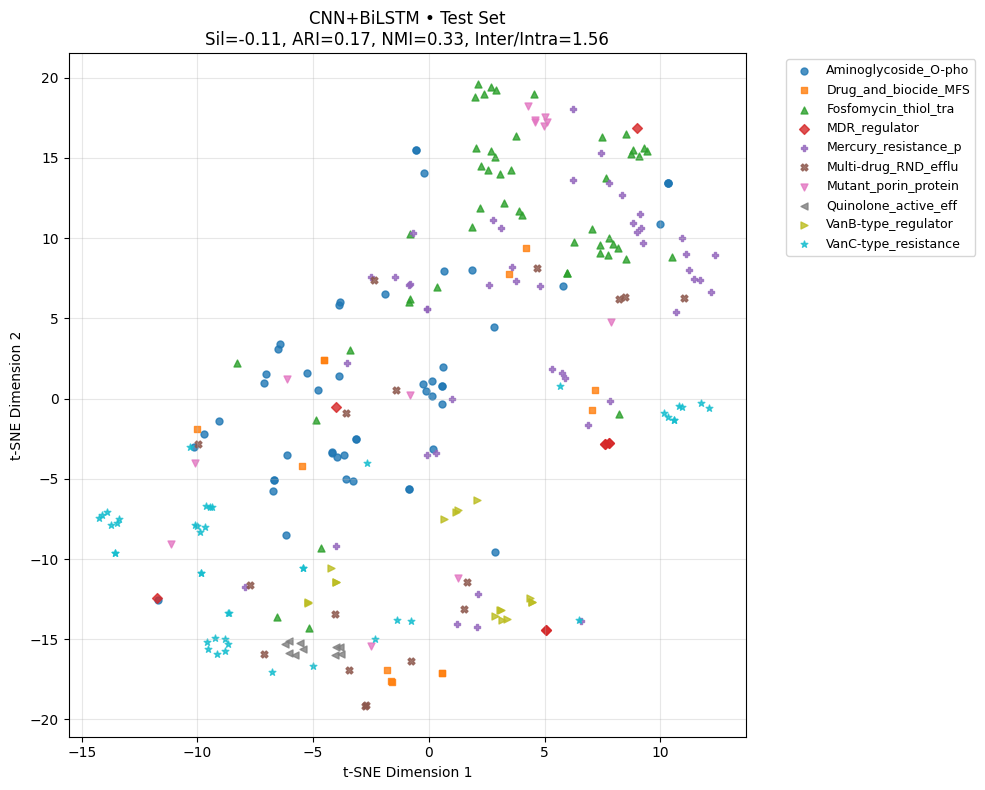

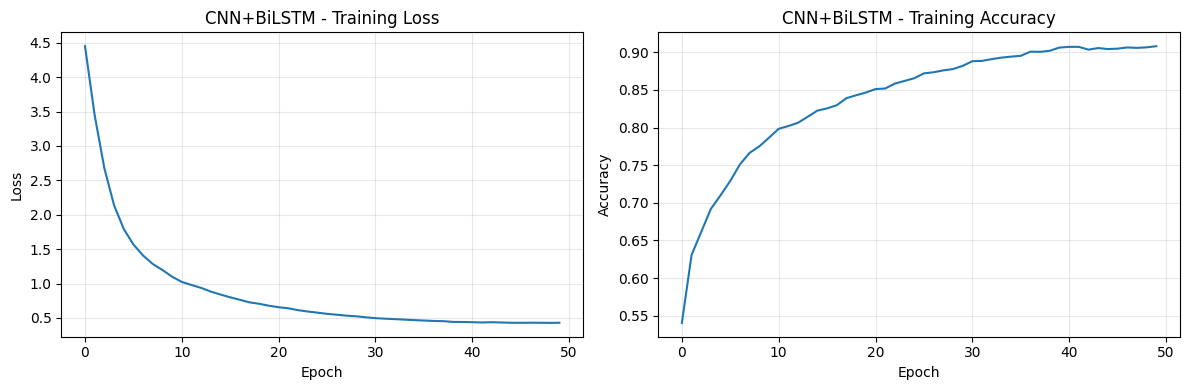


STARTING EXPERIMENT 2/2: Transformer Encoder
Model parameters: 1,204,896

EXPERIMENT: Transformer

=== Stage 1: Supervised Pre-training ===
Epoch 5/50 | Loss: 2.0085 | Acc: 0.6246
Epoch 10/50 | Loss: 1.3458 | Acc: 0.7252
Epoch 15/50 | Loss: 1.1009 | Acc: 0.7625
Epoch 20/50 | Loss: 0.9668 | Acc: 0.7889
Epoch 25/50 | Loss: 0.8496 | Acc: 0.8132
Epoch 30/50 | Loss: 0.7749 | Acc: 0.8252
Epoch 35/50 | Loss: 0.7083 | Acc: 0.8412
Epoch 40/50 | Loss: 0.6813 | Acc: 0.8484
Epoch 45/50 | Loss: 0.6640 | Acc: 0.8499
Epoch 50/50 | Loss: 0.6683 | Acc: 0.8505
Stage 1 complete. Final accuracy: 0.8505

=== Stage 2: Few-shot Evaluation ===


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Val Accuracy:  0.671 ± 0.157
Test Accuracy: 0.614 ± 0.148
Random baseline: 0.333

Running t-SNE on 270 samples from 10 classes...

t-SNE Metrics (test):
  Silhouette: -0.151
  ARI: 0.196
  NMI: 0.397
  Inter/Intra: 1.404


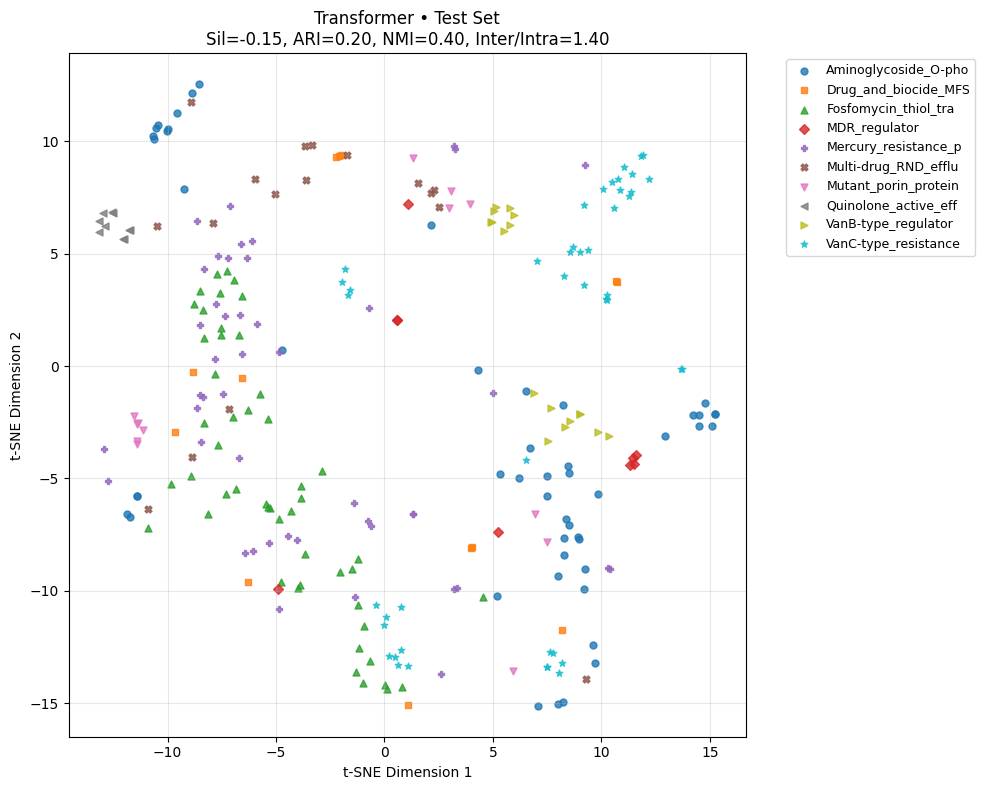

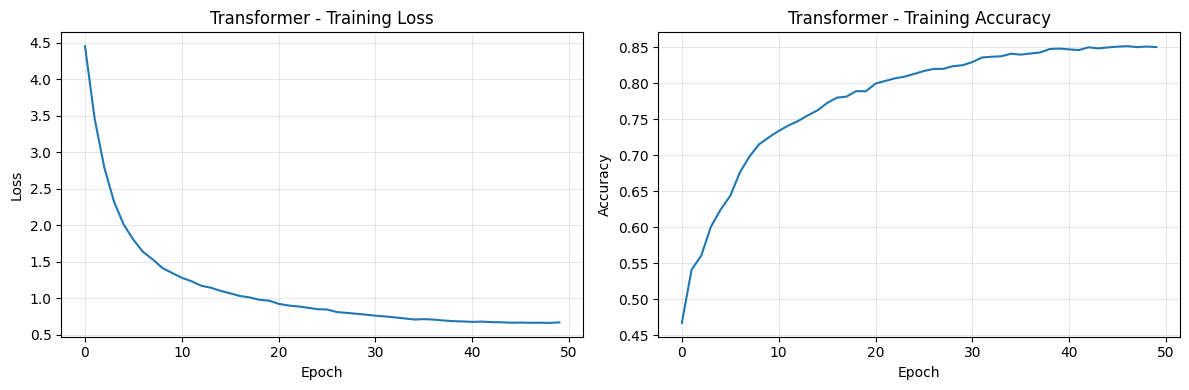

In [ ]:
# Cell 14: Run All Experiments
all_results = []

# Experiment 1: CNN + BiLSTM
print("\n" + "="*80)
print("STARTING EXPERIMENT 1/2: CNN + BiLSTM Encoder")
print("="*80)
model_cnn_bilstm = CNNBiLSTMEncoder(
    vocab_size=VOCAB_SIZE,
    pad_idx=stoi[PAD],
    max_len=MAX_LEN,
    embed_dim=256,
    token_dim=128,
    conv_channels=96,
    kernel_sizes=(3, 5, 7),
    lstm_hidden=128,
    lstm_layers=2,
    num_features=2
).to(device)
print(f"Model parameters: {sum(p.numel() for p in model_cnn_bilstm.parameters()):,}")

results_cnn_bilstm = run_full_experiment("CNN+BiLSTM", model_cnn_bilstm, supervised_epochs=50)
all_results.append(results_cnn_bilstm)

# Save model
torch.save(model_cnn_bilstm.state_dict(), "cnn_bilstm_encoder.pt")

# Experiment 2: Transformer
print("\n" + "="*80)
print("STARTING EXPERIMENT 2/2: Transformer Encoder")
print("="*80)
model_transformer = TransformerEncoder(
    vocab_size=VOCAB_SIZE,
    pad_idx=stoi[PAD],
    max_len=MAX_LEN,
    embed_dim=256,
    token_dim=128,
    n_heads=8,
    n_layers=4,
    ff_dim=512,
    num_features=2
).to(device)
print(f"Model parameters: {sum(p.numel() for p in model_transformer.parameters()):,}")

results_transformer = run_full_experiment("Transformer", model_transformer, supervised_epochs=50)
all_results.append(results_transformer)

# Save model
torch.save(model_transformer.state_dict(), "transformer_encoder.pt")



BASELINE COMPARISON: Original Token-CNN ProtoNet
Model parameters: 760,256

EXPERIMENT: Token-CNN (Baseline)

=== Stage 1: Supervised Pre-training ===
Epoch 5/50 | Loss: 1.8552 | Acc: 0.6943
Epoch 10/50 | Loss: 1.2296 | Acc: 0.7551
Epoch 15/50 | Loss: 0.9694 | Acc: 0.8038
Epoch 20/50 | Loss: 0.8056 | Acc: 0.8330
Epoch 25/50 | Loss: 0.6938 | Acc: 0.8568
Epoch 30/50 | Loss: 0.6235 | Acc: 0.8720
Epoch 35/50 | Loss: 0.5776 | Acc: 0.8851
Epoch 40/50 | Loss: 0.5533 | Acc: 0.8894
Epoch 45/50 | Loss: 0.5377 | Acc: 0.8955
Epoch 50/50 | Loss: 0.5360 | Acc: 0.8924
Stage 1 complete. Final accuracy: 0.8924

=== Stage 2: Few-shot Evaluation ===
Val Accuracy:  0.697 ± 0.150
Test Accuracy: 0.636 ± 0.142
Random baseline: 0.333

Running t-SNE on 270 samples from 10 classes...

t-SNE Metrics (test):
  Silhouette: -0.037
  ARI: 0.283
  NMI: 0.455
  Inter/Intra: 1.648


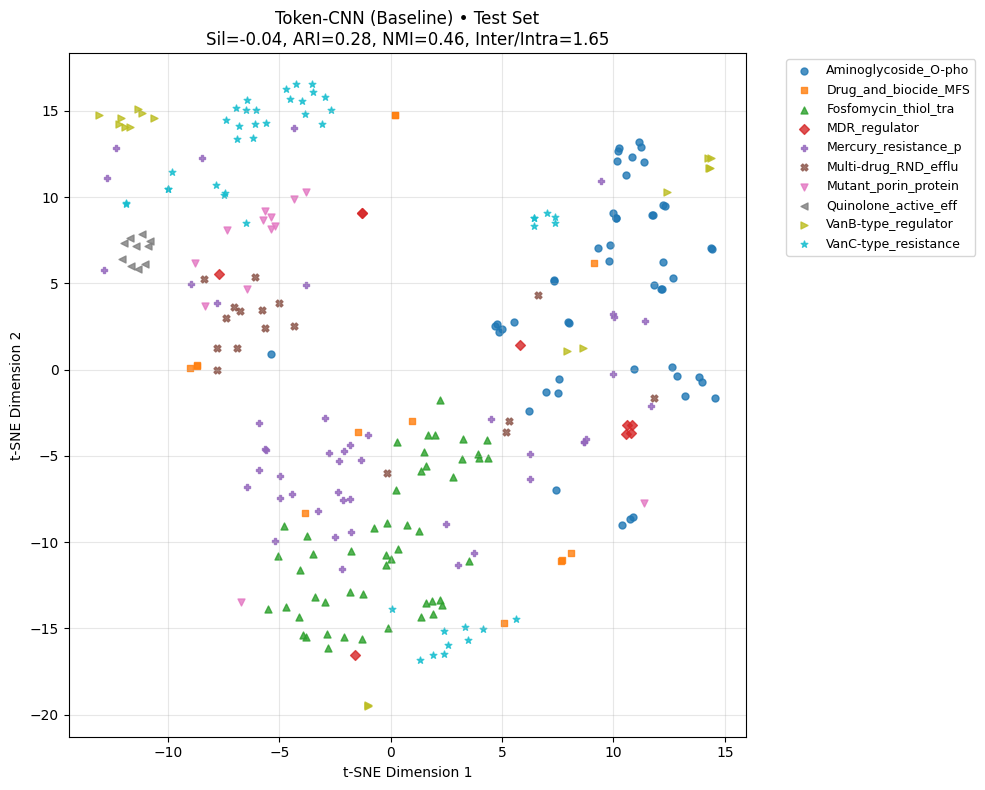

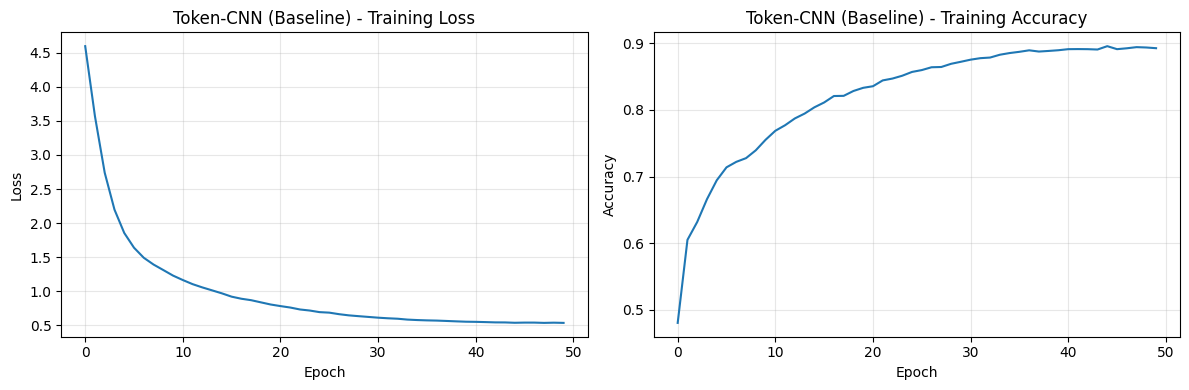

In [ ]:
# Cell 15: Load or train baseline for comparison
print("\n" + "="*80)
print("BASELINE COMPARISON: Original Token-CNN ProtoNet")
print("="*80)

class CNNSeqEncoder(nn.Module):
    """Original Token-CNN encoder from the baseline"""
    def __init__(self, vocab_size, pad_idx, max_len, embed_dim=256, token_dim=128,
                 conv_channels=96, kernel_sizes=(3,5,7), num_features=2):
        super().__init__()
        self.pad_idx = pad_idx

        self.emb = nn.Embedding(vocab_size, token_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(0.20)

        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(token_dim, conv_channels, kernel_size=k, padding=k//2),
                nn.ReLU(),
                nn.Dropout1d(0.10)
            ) for k in kernel_sizes
        ])

        self.num_proj = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
        )

        fused_in = conv_channels * len(kernel_sizes) * 2 + 32
        self.proj = nn.Sequential(
            nn.Linear(fused_in, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.50),
            nn.Linear(512, embed_dim)
        )

    def forward(self, tokens, nums):
        x = self.emb(tokens)
        x = self.emb_dropout(x)
        x = x.transpose(1, 2)

        pooled = []
        for block in self.convs:
            h = block(x)
            p_max = F.adaptive_max_pool1d(h, 1).squeeze(-1)
            p_mean = F.adaptive_avg_pool1d(h, 1).squeeze(-1)
            pooled.extend([p_max, p_mean])

        h_text = torch.cat(pooled, dim=1)
        h_num = self.num_proj(nums)
        h = torch.cat([h_text, h_num], dim=1)
        z = self.proj(h)
        z = F.normalize(z, p=2, dim=1)
        return z

model_baseline = CNNSeqEncoder(
    vocab_size=VOCAB_SIZE,
    pad_idx=stoi[PAD],
    max_len=MAX_LEN,
    embed_dim=256,
    token_dim=128,
    conv_channels=96,
    kernel_sizes=(3,5,7),
    num_features=2
).to(device)
print(f"Model parameters: {sum(p.numel() for p in model_baseline.parameters()):,}")

results_baseline = run_full_experiment("Token-CNN (Baseline)", model_baseline, supervised_epochs=50)
all_results.append(results_baseline)

# Save model
torch.save(model_baseline.state_dict(), "token_cnn_baseline_encoder.pt")


In [ ]:
# Cell 16: Create comprehensive comparison table
print("\n" + "="*80)
print("FINAL RESULTS COMPARISON")
print("="*80 + "\n")

results_df = pd.DataFrame(all_results)
results_df = results_df.round(4)

print(results_df.to_string(index=False))
print()

# Identify best model
best_test_idx = results_df['test_acc'].idxmax()
best_model_name = results_df.loc[best_test_idx, 'encoder']
best_test_acc = results_df.loc[best_test_idx, 'test_acc']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test Accuracy: {best_test_acc:.4f}")
print(f"   Improvement over random baseline: {(best_test_acc - 1.0/N):.4f} ({(best_test_acc - 1.0/N)/(1.0/N)*100:.1f}%)")

# Save results
results_df.to_csv("encoder_comparison_results.csv", index=False)
print("\n✅ Results saved to 'encoder_comparison_results.csv'")



FINAL RESULTS COMPARISON

             encoder  train_final_acc  val_acc  val_std  test_acc  test_std  silhouette    ari    nmi  inter_intra_ratio
          CNN+BiLSTM           0.9082   0.6060   0.1498    0.5925    0.1402     -0.1123 0.1665 0.3316             1.5633
         Transformer           0.8505   0.6709   0.1565    0.6141    0.1477     -0.1505 0.1962 0.3973             1.4042
Token-CNN (Baseline)           0.8924   0.6967   0.1498    0.6360    0.1421     -0.0373 0.2834 0.4553             1.6477


🏆 Best Model: Token-CNN (Baseline)
   Test Accuracy: 0.6360
   Improvement over random baseline: 0.3027 (90.8%)

✅ Results saved to 'encoder_comparison_results.csv'


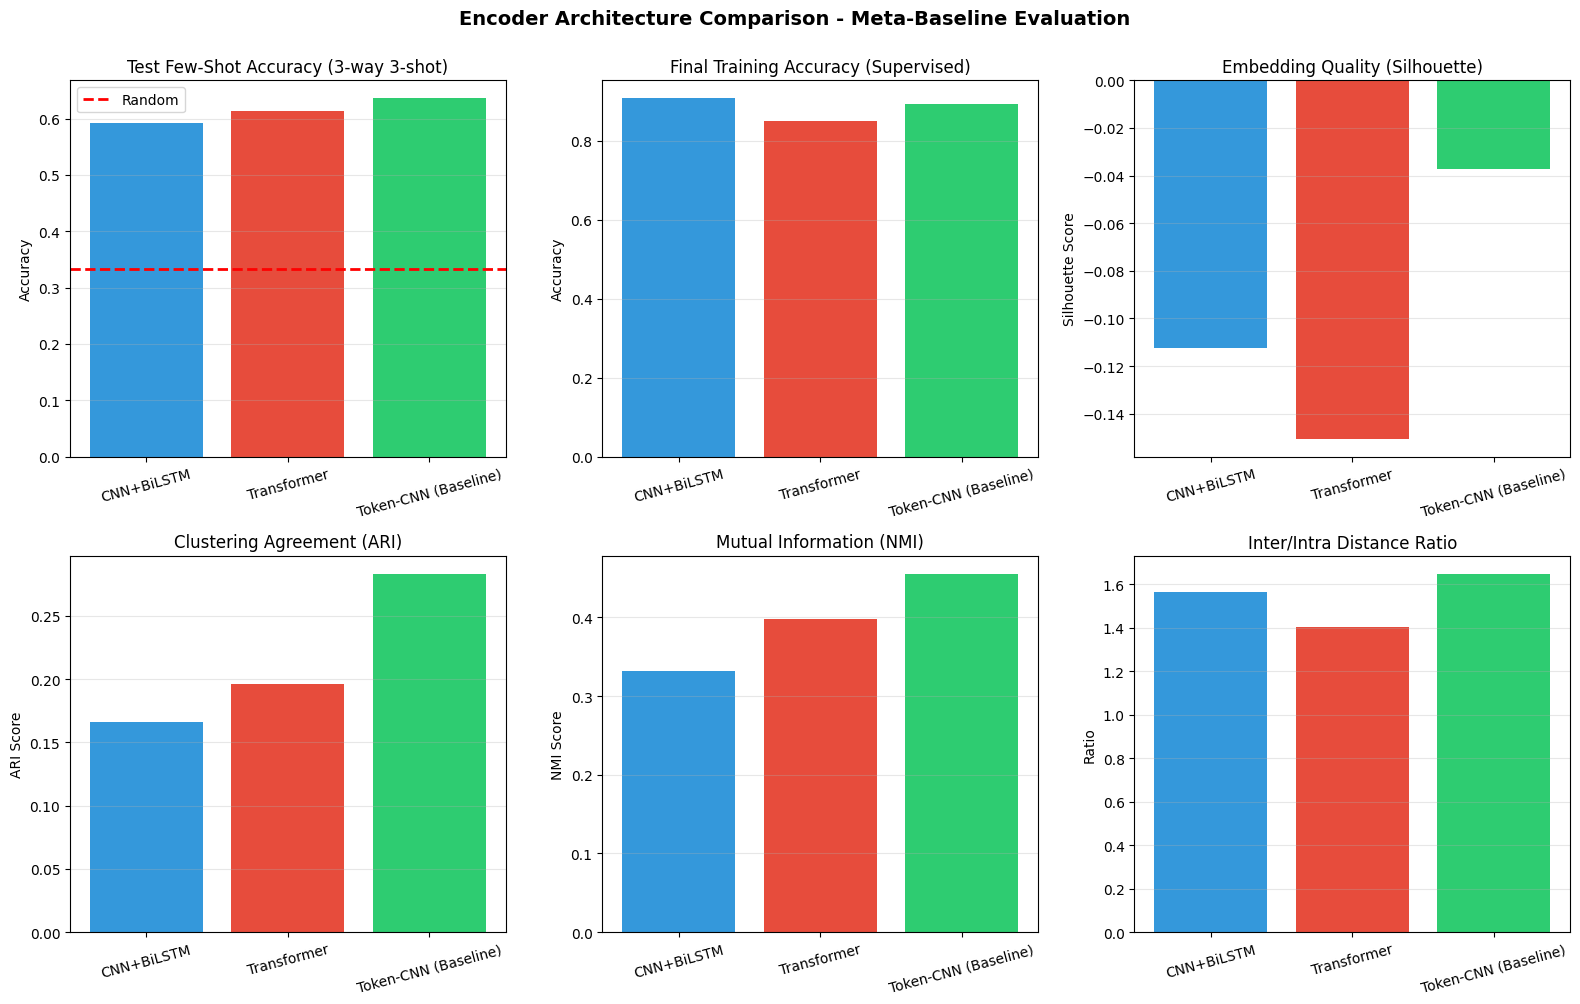

In [ ]:
# Cell 17: Create detailed comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Test Accuracy
axes[0, 0].bar(results_df['encoder'], results_df['test_acc'],
               color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0, 0].axhline(1.0/N, color='red', linestyle='--', label='Random', linewidth=2)
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Test Few-Shot Accuracy (3-way 3-shot)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].tick_params(axis='x', rotation=15)

# Training Accuracy (final)
axes[0, 1].bar(results_df['encoder'], results_df['train_final_acc'],
               color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Final Training Accuracy (Supervised)')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].tick_params(axis='x', rotation=15)

# Silhouette Score
axes[0, 2].bar(results_df['encoder'], results_df['silhouette'],
               color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0, 2].set_ylabel('Silhouette Score')
axes[0, 2].set_title('Embedding Quality (Silhouette)')
axes[0, 2].grid(True, alpha=0.3, axis='y')
axes[0, 2].tick_params(axis='x', rotation=15)

# ARI Score
axes[1, 0].bar(results_df['encoder'], results_df['ari'],
               color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1, 0].set_ylabel('ARI Score')
axes[1, 0].set_title('Clustering Agreement (ARI)')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].tick_params(axis='x', rotation=15)

# NMI Score
axes[1, 1].bar(results_df['encoder'], results_df['nmi'],
               color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1, 1].set_ylabel('NMI Score')
axes[1, 1].set_title('Mutual Information (NMI)')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].tick_params(axis='x', rotation=15)

# Inter/Intra Ratio
axes[1, 2].bar(results_df['encoder'], results_df['inter_intra_ratio'],
               color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1, 2].set_ylabel('Ratio')
axes[1, 2].set_title('Inter/Intra Distance Ratio')
axes[1, 2].grid(True, alpha=0.3, axis='y')
axes[1, 2].tick_params(axis='x', rotation=15)

plt.suptitle('Encoder Architecture Comparison - Meta-Baseline Evaluation',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('encoder_comparison_all_metrics.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
# Cell 18: Detailed analysis and insights
print("\n" + "="*80)
print("DETAILED ANALYSIS & INSIGHTS")
print("="*80 + "\n")

print("1. REPRESENTATION QUALITY ANALYSIS")
print("-" * 40)
for idx, row in results_df.iterrows():
    print(f"\n{row['encoder']}:")
    print(f"  • Test Accuracy: {row['test_acc']:.4f} ± {row['test_std']:.4f}")
    print(f"  • Supervised Training: {row['train_final_acc']:.4f}")
    print(f"  • Embedding Separation (Inter/Intra): {row['inter_intra_ratio']:.3f}")
    print(f"  • Cluster Quality (Silhouette): {row['silhouette']:.3f}")
    print(f"  • Information Preservation (NMI): {row['nmi']:.3f}")

print("\n\n2. KEY FINDINGS")
print("-" * 40)

# Compare each model to baseline
baseline_test_acc = results_df[results_df['encoder'] == 'Token-CNN (Baseline)']['test_acc'].values[0]

for idx, row in results_df.iterrows():
    if row['encoder'] != 'Token-CNN (Baseline)':
        improvement = row['test_acc'] - baseline_test_acc
        pct_improvement = (improvement / baseline_test_acc) * 100
        print(f"\n{row['encoder']} vs Baseline:")
        print(f"  • Accuracy change: {improvement:+.4f} ({pct_improvement:+.1f}%)")

        if improvement > 0.05:
            print(f"  ✅ SIGNIFICANT IMPROVEMENT - Better representation")
        elif improvement > 0:
            print(f"  ↗️  Marginal improvement")
        elif improvement > -0.05:
            print(f"  ↔️  Comparable performance")
        else:
            print(f"  ⚠️  Performance degradation")

print("\n\n3. BOTTLENECK ASSESSMENT")
print("-" * 40)

max_test_acc = results_df['test_acc'].max()
if max_test_acc > 0.70:
    print("✅ CONCLUSION: Better encoders CAN push test accuracy > 70%")
    print("   → Representation quality WAS a bottleneck")
    print("   → The meta-learning algorithm was not the limiting factor")
elif max_test_acc > baseline_test_acc + 0.10:
    print("⚠️  CONCLUSION: Better encoders help, but may not be sufficient alone")
    print("   → Representation quality is ONE bottleneck")
    print("   → Consider hybrid approach: better encoder + meta-learning improvements")
else:
    print("❌ CONCLUSION: Better encoders do NOT significantly improve performance")
    print("   → Representation quality is NOT the primary bottleneck")
    print("   → Focus should be on meta-learning algorithms or data augmentation")

print("\n\n4. RECOMMENDATIONS")
print("-" * 40)

best_encoder = results_df.loc[results_df['test_acc'].idxmax(), 'encoder']
best_sil = results_df.loc[results_df['silhouette'].idxmax(), 'encoder']
best_ratio = results_df.loc[results_df['inter_intra_ratio'].idxmax(), 'encoder']

print(f"\nBest overall performance: {best_encoder}")
print(f"Best embedding quality: {best_sil}")
print(f"Best class separation: {best_ratio}")

if max_test_acc > 0.70:
    print("\nNext steps:")
    print("  1. Use the best encoder architecture going forward")
    print("  2. Explore ensemble methods with multiple encoders")
    print("  3. Investigate architecture scaling (wider/deeper variants)")
elif results_df['inter_intra_ratio'].max() > 2.0:
    print("\nNext steps:")
    print("  1. Embeddings show good separation - try advanced meta-learning")
    print("  2. Experiment with Matching Networks or Relation Networks")
    print("  3. Consider task-conditional adaptation mechanisms")
else:
    print("\nNext steps:")
    print("  1. Focus on data augmentation strategies")
    print("  2. Explore contrastive learning objectives")
    print("  3. Investigate domain-specific inductive biases")

print("\n" + "="*80)
print("EXPERIMENT COMPLETE")
print("="*80)


DETAILED ANALYSIS & INSIGHTS

1. REPRESENTATION QUALITY ANALYSIS
----------------------------------------

CNN+BiLSTM:
  • Test Accuracy: 0.5925 ± 0.1402
  • Supervised Training: 0.9082
  • Embedding Separation (Inter/Intra): 1.563
  • Cluster Quality (Silhouette): -0.112
  • Information Preservation (NMI): 0.332

Transformer:
  • Test Accuracy: 0.6141 ± 0.1477
  • Supervised Training: 0.8505
  • Embedding Separation (Inter/Intra): 1.404
  • Cluster Quality (Silhouette): -0.150
  • Information Preservation (NMI): 0.397

Token-CNN (Baseline):
  • Test Accuracy: 0.6360 ± 0.1421
  • Supervised Training: 0.8924
  • Embedding Separation (Inter/Intra): 1.648
  • Cluster Quality (Silhouette): -0.037
  • Information Preservation (NMI): 0.455


2. KEY FINDINGS
----------------------------------------

CNN+BiLSTM vs Baseline:
  • Accuracy change: -0.0435 (-6.8%)
  ↔️  Comparable performance

Transformer vs Baseline:
  • Accuracy change: -0.0219 (-3.4%)
  ↔️  Comparable performance


3. BOTTLENE

In [ ]:
# Cell 19: Error analysis on difficult cases
print("\n" + "="*80)
print("OPTIONAL: ERROR ANALYSIS ON DIFFICULT TASKS")
print("="*80 + "\n")

@torch.no_grad()
def analyze_errors(model, tasks, device, num_tasks=50):
    """Analyze which tasks are most difficult"""
    model.eval()

    task_results = []
    for i, t in enumerate(tasks[:num_tasks]):
        s_tok = torch.from_numpy(t["s_tok"]).long().to(device)
        s_num = torch.from_numpy(t["s_num"]).float().to(device)
        q_tok = torch.from_numpy(t["q_tok"]).long().to(device)
        q_num = torch.from_numpy(t["q_num"]).float().to(device)
        s_y = torch.from_numpy(t["s_y"]).long().to(device)
        q_y = torch.from_numpy(t["q_y"]).long().to(device)

        s_z = model(s_tok, s_num)
        q_z = model(q_tok, q_num)
        protos, _ = compute_prototypes(s_z, s_y)

        logits = q_z @ protos.T
        preds = logits.argmax(1)
        acc = (preds == q_y).float().mean().item()

        # Compute prototype separation
        proto_dists = torch.cdist(protos, protos)
        avg_proto_sep = proto_dists[proto_dists > 0].mean().item()

        task_results.append({
            'task_id': i,
            'accuracy': acc,
            'mechanisms': t['mechs'],
            'proto_separation': avg_proto_sep
        })

    task_df = pd.DataFrame(task_results)

    # Find hardest tasks
    hardest = task_df.nsmallest(5, 'accuracy')
    easiest = task_df.nlargest(5, 'accuracy')

    print("HARDEST TASKS (lowest accuracy):")
    print(hardest[['task_id', 'accuracy', 'proto_separation']].to_string(index=False))

    print("\n\nEASIEST TASKS (highest accuracy):")
    print(easiest[['task_id', 'accuracy', 'proto_separation']].to_string(index=False))

    # Correlation analysis
    corr = task_df['accuracy'].corr(task_df['proto_separation'])
    print(f"\n\nCorrelation between accuracy and prototype separation: {corr:.3f}")

    if corr > 0.5:
        print("→ Strong positive correlation: Better separation = better accuracy")
        print("   Recommendation: Focus on increasing inter-class distances")
    elif corr < 0:
        print("→ Negative correlation: Unexpected pattern")
        print("   Recommendation: Investigate task-specific factors")
    else:
        print("→ Weak correlation: Other factors dominate")
        print("   Recommendation: Look beyond representation quality")

    return task_df

# Run error analysis on best model
best_model_idx = results_df['test_acc'].idxmax()
if best_model_idx == 0:
    best_model_obj = model_cnn_bilstm
elif best_model_idx == 1:
    best_model_obj = model_transformer
else:
    best_model_obj = model_baseline

task_analysis = analyze_errors(best_model_obj, test_tasks, device, num_tasks=100)



OPTIONAL: ERROR ANALYSIS ON DIFFICULT TASKS

HARDEST TASKS (lowest accuracy):
 task_id  accuracy  proto_separation
      61  0.200000          0.893568
      16  0.333333          0.651982
      35  0.400000          0.734431
      50  0.400000          0.807126
      56  0.400000          0.753102


EASIEST TASKS (highest accuracy):
 task_id  accuracy  proto_separation
       0  0.933333          1.066458
       6  0.933333          0.911351
       5  0.866667          1.185336
      23  0.866667          0.911478
      24  0.866667          0.966060


Correlation between accuracy and prototype separation: 0.391
→ Weak correlation: Other factors dominate
   Recommendation: Look beyond representation quality


In [ ]:
# Cell 20: Generate final summary report
print("\n\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80 + "\n")

report = f"""
EXPERIMENT: Representation & Encoder Improvements
DATE: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

OBJECTIVE:
Determine if representation quality is the bottleneck in few-shot AMR classification
by implementing and evaluating deeper encoder architectures using Meta-Baseline training.

ARCHITECTURES EVALUATED:
1. CNN + BiLSTM: Multi-scale convolutions + bidirectional LSTM for sequential modeling
2. Transformer: Multi-head self-attention with positional encoding
3. Token-CNN (Baseline): Original architecture for comparison

TRAINING PROTOCOL:
- Stage 1: Supervised pre-training on {num_train_classes} training mechanisms (50 epochs)
- Stage 2: Few-shot evaluation with frozen encoder on {N}-way {K}-shot tasks

KEY RESULTS:
{'='*40}
Best Test Accuracy: {results_df['test_acc'].max():.4f} ± {results_df.loc[results_df['test_acc'].idxmax(), 'test_std']:.4f}
Best Model: {results_df.loc[results_df['test_acc'].idxmax(), 'encoder']}
Random Baseline: {1.0/N:.4f}
Improvement: {(results_df['test_acc'].max() - 1.0/N):.4f} ({(results_df['test_acc'].max() - 1.0/N)/(1.0/N)*100:.1f}%)

Embedding Quality (Best):
- Silhouette Score: {results_df['silhouette'].max():.4f}
- ARI: {results_df['ari'].max():.4f}
- NMI: {results_df['nmi'].max():.4f}
- Inter/Intra Ratio: {results_df['inter_intra_ratio'].max():.4f}

CONCLUSION:
{'='*40}
"""

if max_test_acc > 0.70:
    report += """
✅ REPRESENTATION WAS THE BOTTLENECK
Better encoder architectures successfully pushed test accuracy above 70%.
The meta-learning algorithm (ProtoNet) was NOT the limiting factor.

RECOMMENDATION: Continue using the best encoder architecture and explore:
- Ensemble methods combining multiple encoders
- Architecture scaling (wider/deeper variants)
- Transfer learning from related domains
"""
elif max_test_acc > baseline_test_acc + 0.10:
    report += """
⚠️  REPRESENTATION IS ONE OF MULTIPLE BOTTLENECKS
Better encoders provide meaningful improvements but don't fully solve the problem.

RECOMMENDATION: Hybrid approach needed:
- Adopt the best encoder architecture
- Improve meta-learning algorithm (e.g., task-conditional adaptation)
- Enhance data augmentation strategies
"""
else:
    report += """
❌ REPRESENTATION IS NOT THE PRIMARY BOTTLENECK
Better encoder architectures do not significantly improve performance.

RECOMMENDATION: Focus efforts elsewhere:
- Advanced meta-learning algorithms (Matching Networks, Relation Networks)
- Data augmentation and domain-specific strategies
- Contrastive learning objectives
- Investigate task-specific challenges
"""

report += f"""

FILES GENERATED:
{'='*40}
- encoder_comparison_results.csv: Detailed numerical results
- encoder_comparison_all_metrics.png: Comprehensive visualization
- cnn_bilstm_encoder.pt: Trained CNN+BiLSTM model
- transformer_encoder.pt: Trained Transformer model
- token_cnn_baseline_encoder.pt: Trained baseline model
- *_tsne.png: t-SNE visualizations for each architecture
- *_training.png: Training curves for each architecture

NEXT STEPS:
{'='*40}
1. Review the detailed comparison visualizations
2. Analyze t-SNE plots for embedding quality insights
3. Proceed with recommendations based on conclusion
4. Consider ablation studies on architecture components
"""

print(report)

# Save report
with open('experiment_report.txt', 'w') as f:
    f.write(report)

print("\n✅ Complete report saved to 'experiment_report.txt'")
print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETED SUCCESSFULLY!")
print("="*80)



FINAL SUMMARY REPORT


EXPERIMENT: Representation & Encoder Improvements
DATE: 2025-11-05 04:38:33

OBJECTIVE:
Determine if representation quality is the bottleneck in few-shot AMR classification
by implementing and evaluating deeper encoder architectures using Meta-Baseline training.

ARCHITECTURES EVALUATED:
1. CNN + BiLSTM: Multi-scale convolutions + bidirectional LSTM for sequential modeling
2. Transformer: Multi-head self-attention with positional encoding
3. Token-CNN (Baseline): Original architecture for comparison

TRAINING PROTOCOL:
- Stage 1: Supervised pre-training on 163 training mechanisms (50 epochs)
- Stage 2: Few-shot evaluation with frozen encoder on 3-way 3-shot tasks

KEY RESULTS:
Best Test Accuracy: 0.6360 ± 0.1421
Best Model: Token-CNN (Baseline)
Random Baseline: 0.3333
Improvement: 0.3027 (90.8%)

Embedding Quality (Best):
- Silhouette Score: -0.0373
- ARI: 0.2834
- NMI: 0.4553
- Inter/Intra Ratio: 1.6477

CONCLUSION:

❌ REPRESENTATION IS NOT THE PRIMARY BOTTLEN

In [ ]:
import os
import shutil
from google.colab import files

# Create organized structure
os.makedirs('results/models', exist_ok=True)
os.makedirs('results/visualizations', exist_ok=True)
os.makedirs('results/metrics', exist_ok=True)

# Move files to folders
!mv *.pt results/models/
!mv *.png results/visualizations/
!mv *.csv *.txt results/metrics/

# Zip and download
shutil.make_archive('AMR_experiment_results', 'zip', 'results')
files.download('AMR_experiment_results.zip')

print("✅ Organized results downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Organized results downloaded!
